Import core numerical and utility functionality

In [1]:
import numpy as np
from numba import jit, njit, prange
import pandas as pd
import scipy.stats as stats
from scipy.optimize import curve_fit

import random

import matplotlib.pyplot as plt
import matplotlib.animation as animation

import logbook
from logbook import Logger, StreamHandler, FileHandler, DEBUG, INFO, WARNING, ERROR, NOTSET
from tqdm.notebook import tqdm

import os
import time
import sys

Setup

In [2]:
np.random.seed(42)

NAME = 'assignment1'
DATA_PATH = f'data/{NAME}'
MEDIA_PATH = f'media/{NAME}'
LOG_PATH = f'log/{NAME}'
[os.makedirs(path, exist_ok=True) for path in [DATA_PATH, MEDIA_PATH, LOG_PATH]]

ANIM_BACKEND = 'ffmpeg'
LOAD_CACHED_FILES_IF_AVAILABLE = True

log = Logger(f'{NAME}_logger')
fh = FileHandler(f'{LOG_PATH}/log.log', mode='w', level=DEBUG, bubble=True)
fh.push_application()
sh = StreamHandler(sys.stdout, level=WARNING, bubble=True)
sh.push_application()

## Michaelis-Menten Equation

In [24]:
def michaelis_menten(substrate, km, vmax):
    return vmax * substrate / (km + substrate)

def plot_michaelis_menten(substrate_range, km, vmax, color='tab:blue'):
    v = michaelis_menten(substrate_range, km, vmax)
    fig = plt.figure(figsize=(4, 3), dpi=300, layout='tight')
    plt.plot(substrate_range, v, color=color)
    plt.xlabel('Substrate concentration $[S]$')
    plt.ylim(0, vmax*1.05)
    plt.yticks([0, vmax/2, vmax], ['0', '$\\frac{V_{max}}{2}$', '$V_{{max}}$'])
    plt.ylabel('Reaction rate $v$')
    plt.title(f'Michaelis-Menten kinetics')
    plt.legend([f'$K_m={km}, V_{{max}}={vmax}$'])
    return fig

def plot_comparison_michaelis_menten(substrate_range, kms, vmaxs, colors):
    fig = plt.figure(figsize=(4, 3), dpi=300, layout='tight')
    for km, vmax, color in zip(kms, vmaxs, colors):
        v = michaelis_menten(substrate_range, km, vmax)
        plt.plot(substrate_range, v, label=f'$K_m={km}, V_{{max}}={vmax}$', color=color)
    plt.xlabel('Substrate concentration $[S]$')
    plt.ylabel('Reaction rate $v$')
    plt.title(f'Michaelis-Menten kinetics')
    plt.legend()
    return fig

Visualize Michaelis-Menten kinetics using the corresponding equation

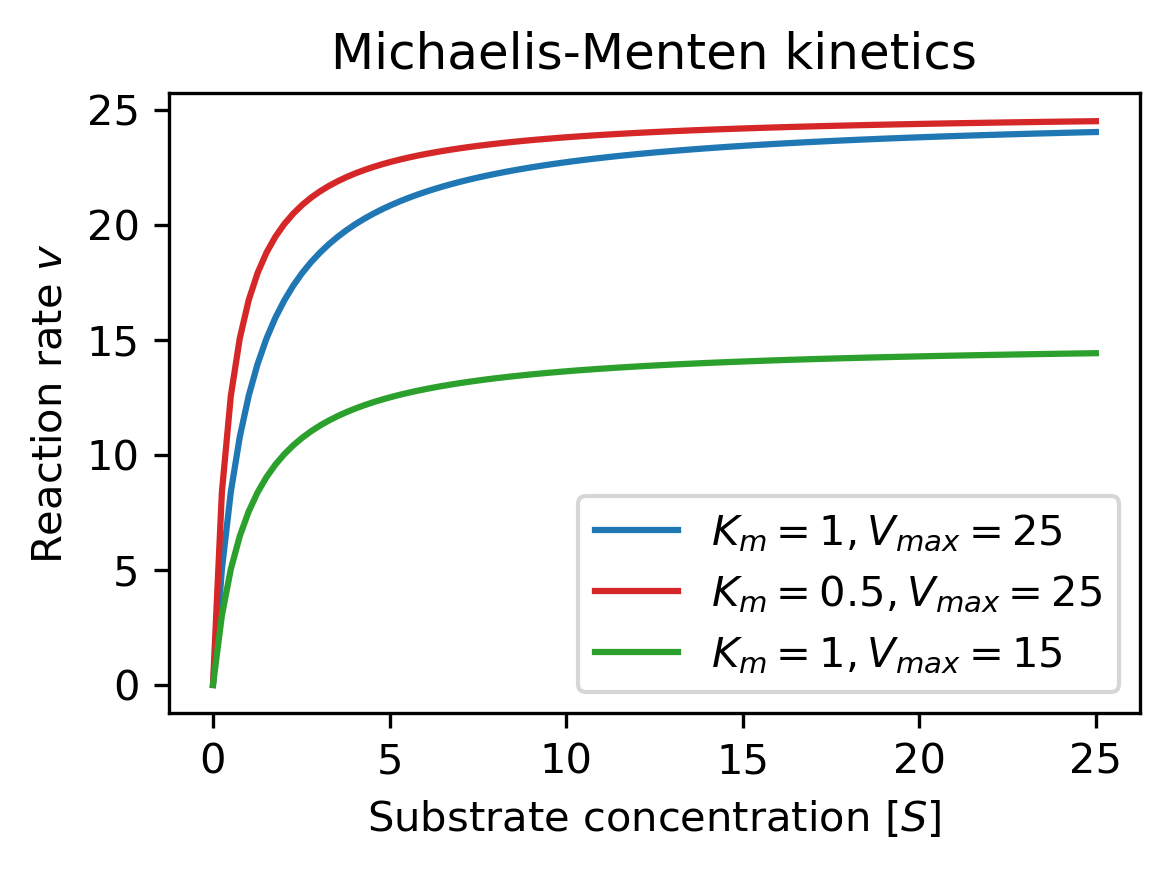

In [18]:
substrate = np.linspace(0, 25, 100)
kms = [1, 0.5, 1]
vmaxs = [25, 25, 15]
colors = ['tab:blue', 'tab:red', 'tab:green']
for km, vmax, color in zip(kms, vmaxs, colors):
    fig = plot_michaelis_menten(substrate, km, vmax, color=color)
    fig.savefig(f'{MEDIA_PATH}/michaelis_menten_km={km}_vmax={vmax}.png', bbox_inches='tight')
    plt.close(fig)
fig_comp = plot_comparison_michaelis_menten(substrate, kms, vmaxs, colors)
fig_comp.savefig(f'{MEDIA_PATH}/michaelis_menten_comparison.png', bbox_inches='tight')

Import data and estimate parameters using `scipy.optimize.curve_fit`

In [19]:
# Import data
data = pd.read_csv('data/measuredData.csv', sep=',', names=['[S]', '[V]'])

# Fit data
log.info('Fitting data...')
model = curve_fit(lambda x, km, vmax: vmax * x / (km + x), data['[S]'], data['[V]'], p0=[1, 1])
km, vmax = model[0]
log.info(f'Fitted Michaelis-Menten model: Km={km}, Vmax={vmax}')

x = np.linspace(0, max(data['[S]']), 100)
data_fitted = michaelis_menten(x, km, vmax)

Visualize dataset and fitted function

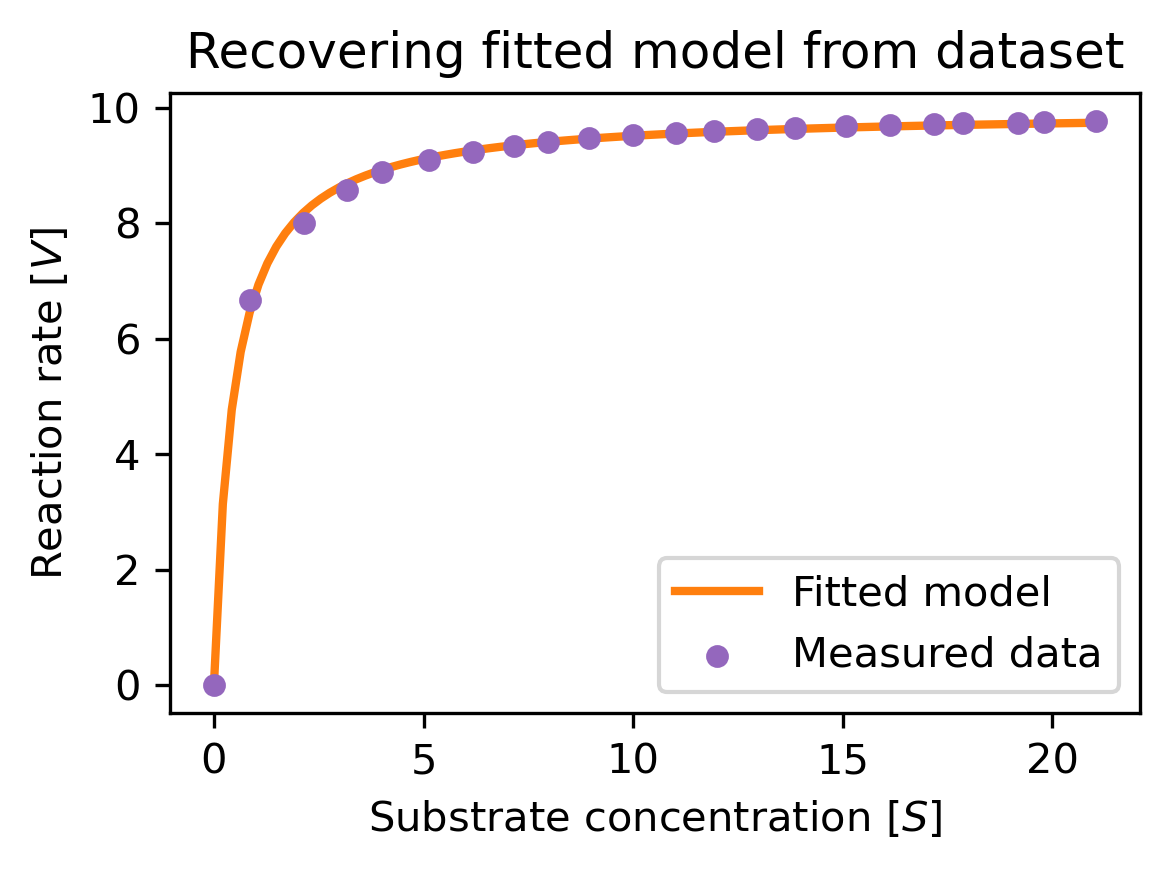

In [20]:
fig = plt.figure(figsize=(4, 3), dpi=300, layout='tight')
plt.plot(x, data_fitted, color='tab:orange', label='Fitted model', linewidth=2)
plt.scatter(data['[S]'], data['[V]'], s=20, color='tab:purple', label='Measured data', zorder=2)
plt.xlabel('Substrate concentration $[S]$')
plt.ylabel('Reaction rate $[V]$')
plt.legend()
plt.title('Recovering fitted model from dataset')
fig.savefig(f'{MEDIA_PATH}/fitted_model_from_dataset.png', bbox_inches='tight')

## Lineweaver-Burk

In [21]:
fh.close()
fh = FileHandler(f'{LOG_PATH}/log2.log', mode='w', level=DEBUG, bubble=True)
fh.push_application()

In [22]:
def plot_lineweaver_burk(substrate_range, km, vmax, color='tab:blue'):
    v = michaelis_menten(substrate_range, km, vmax)
    fig = plt.figure(figsize=(4, 3), dpi=300, layout='tight')
    plt.plot(1/substrate_range, 1/v, color=color)
    plt.xlabel('Substrate concentration inverse $\\frac{1}{[S]}$')
    plt.ylabel('Reaction rate inverse $\\frac{1}{v}$')
    plt.title(f'Lineweaver-Burk visualization')
    plt.legend([f'$K_m={km:.2f}, V_{{max}}={vmax:.2f}$'])
    return fig

/var/folders/tg/bfb__1d16td__2vd879zjkrh0000gn/T/ipykernel_59812/2445658621.py:4: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1/substrate_range, 1/v, color=color)


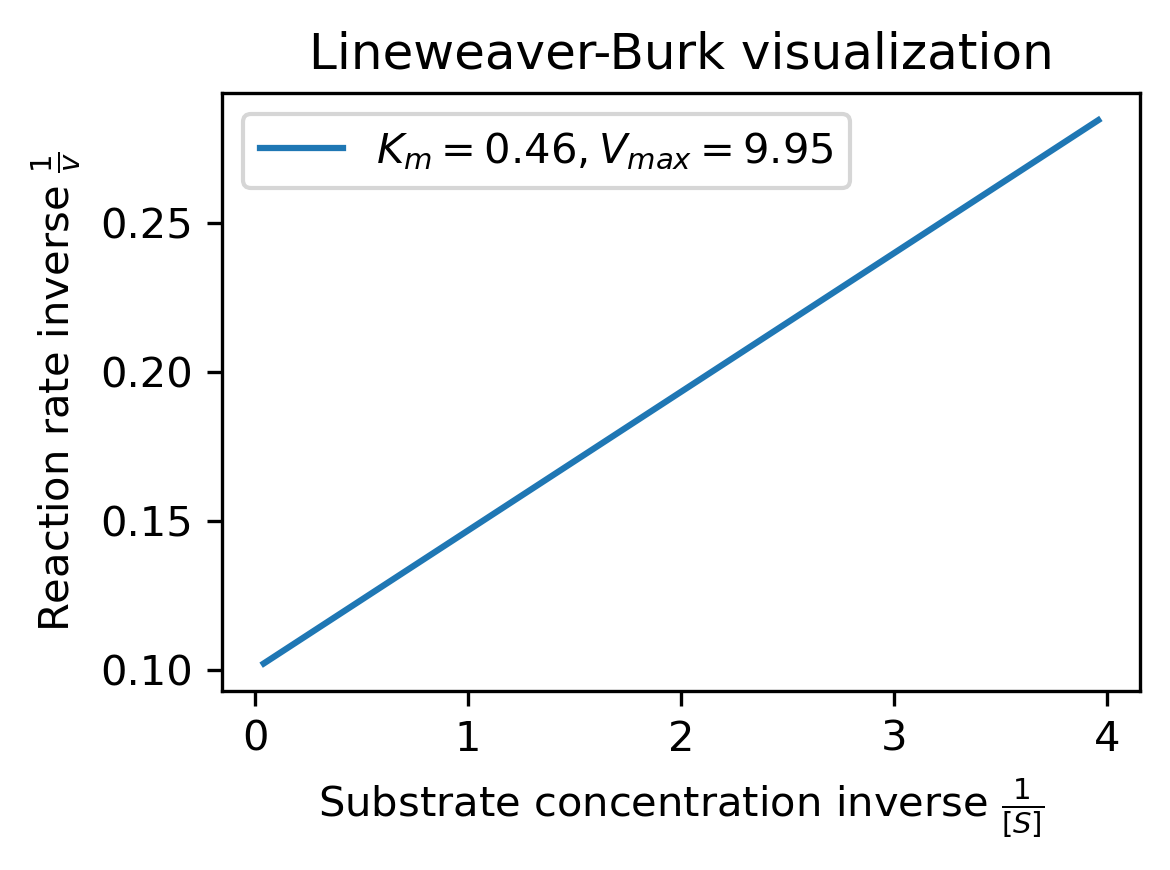

In [23]:
fig = plot_lineweaver_burk(substrate, km, vmax)
fig.savefig(f'{MEDIA_PATH}/lineweaver_burk.png', bbox_inches='tight')

$$ 
V = V_{max} \cdot \frac{S}{K_M + S} \\
\ \\
V^{-1} = (V_{max} \cdot \frac{S}{K_M + S})^{-1} \\
\ \\
\frac{1}{V} = \frac{1}{V_{max}} \cdot \frac{K_M + S}{S}\\
\ \\
\frac{1}{V} = \frac{1}{V_{max}} \cdot (\frac{K_M}{S} + \frac{S}{S})\\
\ \\
\frac{1}{V} = \frac{1}{V_{max}} \cdot (\frac{K_M}{S} + 1)\\
\ \\
\frac{1}{V} = \frac{1}{V_{max}} + \frac{K_M}{V_{max}} \cdot \frac{1}{S} \\
$$

In [47]:
fh.close()
sh.close()